In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
%matplotlib inline

from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller #for Augmented Dickey fuller test
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from pandas.plotting import register_matplotlib_converters

from pandas.plotting import autocorrelation_plot



register_matplotlib_converters()

In [2]:
%pwd

'C:\\Users\\jsingh\\Desktop\\Work\\SalesPrediction'

In [3]:
df=pd.read_csv('SalesOrder2018.csv')

In [4]:
df

,Date,Orders
0,1-2018,14375.67
1,2-2018,15635.32
2,3-2018,13526.79
3,4-2018,19046.00
4,5-2018,11703.39
5,6-2018,30758.99
6,7-2018,28804.88
7,8-2018,17307.73
8,9-2018,33468.42
9,10-2018,17646.19


In [5]:
df.head()

,Date,Orders
0,1-2018,14375.67
1,2-2018,15635.32
2,3-2018,13526.79
3,4-2018,19046.00
4,5-2018,11703.39


In [6]:
df.tail()

,Date,Orders
32,9-2020,20597.52
33,10-2020,81762.00
34,11-2020,43255.55
35,12-2020,33082.96
36,1-2021,34195.00


In [7]:
# Converting Date into Datetime format
df['Date']=pd.to_datetime(df['Date'])

In [8]:
df.head()

,Date,Orders
0,2018-01-01,14375.67
1,2018-02-01,15635.32
2,2018-03-01,13526.79
3,2018-04-01,19046.00
4,2018-05-01,11703.39


In [9]:
df.to_csv('SalesOrder2018-New.csv', index = False)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    37 non-null     datetime64[ns]
 1   Orders  37 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 720.0 bytes


In [11]:
df.describe()

,Orders
count,37.000000
mean,33400.916216
std,23359.345363
min,11703.390000
25%,17307.730000
50%,22161.030000
75%,37685.030000
max,87860.080000


In [12]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Orders', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.plot(x, y, color='tab:Blue', marker='o')
    plt.show()

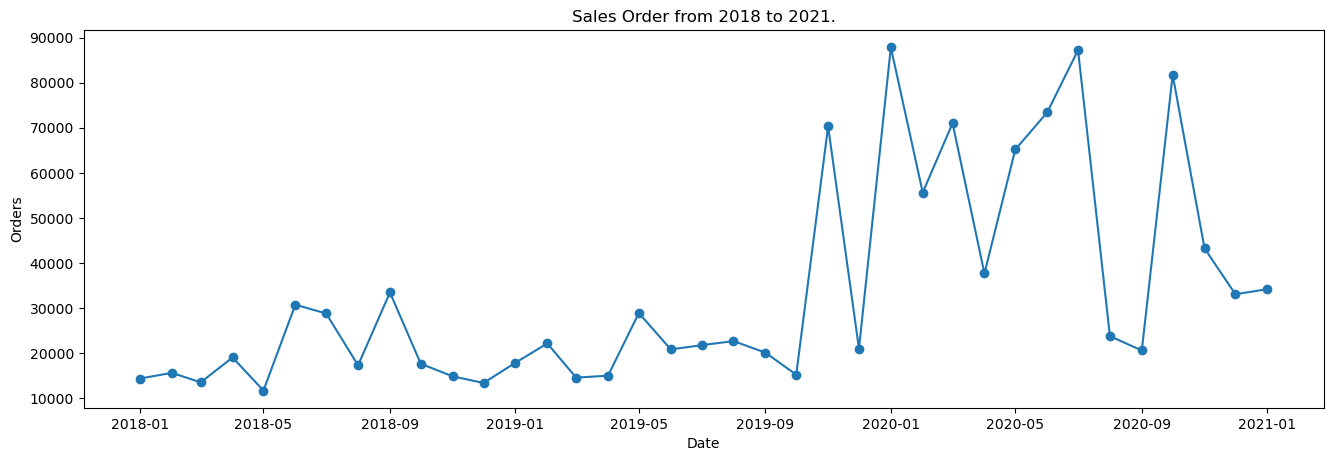

In [13]:

plot_df(df, x=df.Date, y=df.Orders,title='Sales Order from 2018 to 2021.')

In [14]:
df['Year'] = [d.year for d in df.Date]
df['Month'] = [d.strftime('%b') for d in df.Date]
years = df['Year'].unique()

In [15]:
df.head()

,Date,Orders,Year,Month
0,2018-01-01,14375.67,2018,Jan
1,2018-02-01,15635.32,2018,Feb
2,2018-03-01,13526.79,2018,Mar
3,2018-04-01,19046.00,2018,Apr
4,2018-05-01,11703.39,2018,May


In [16]:
#Colors
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)


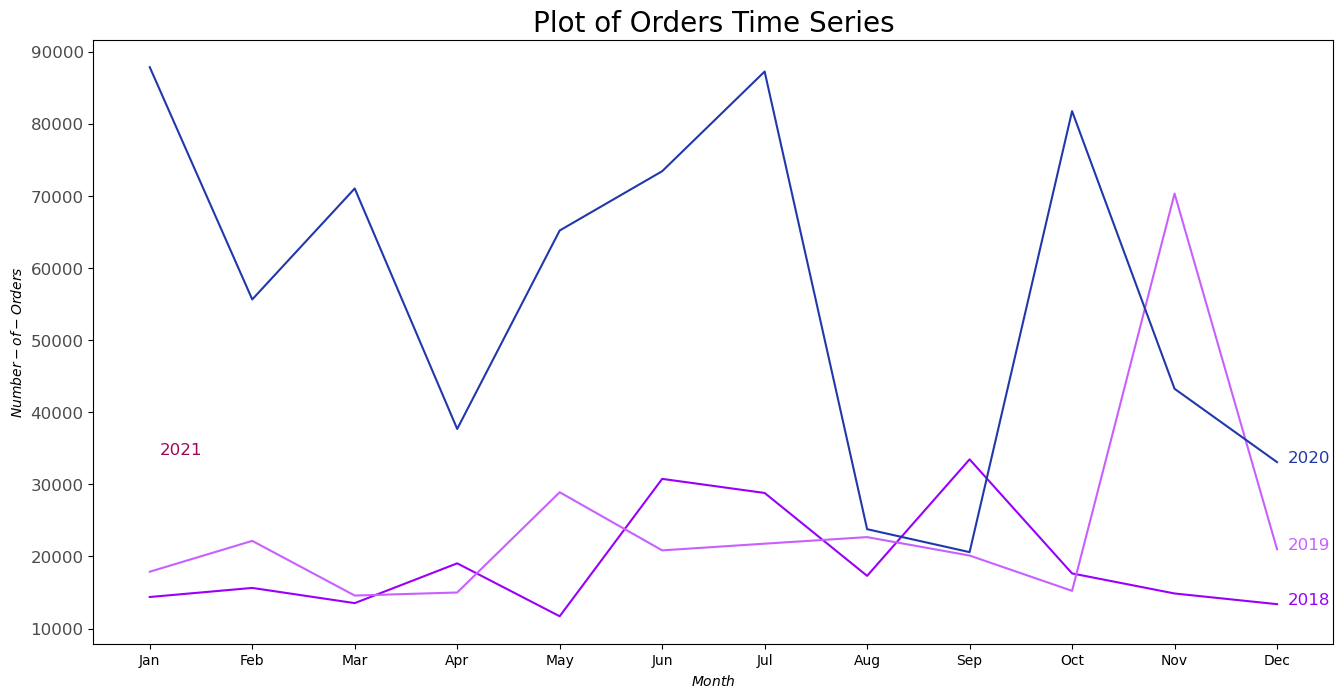

In [17]:
#Plot
plt.figure(figsize=(16,8), dpi= 100)
for i, y in enumerate(years):
    if i >= 0:        
        plt.plot('Month', 'Orders', data=df.loc[df.Year==y, :], color=mycolors[i], label=y)
        plt.text(df.loc[df.Year==y, :].shape[0]-.9, df.loc[df.Year==y, 'Orders'][-1:].values[0], y, fontsize=12, color=mycolors[i])


# Decoration
plt.gca().set(ylabel='$Number-of-Orders$', xlabel='$Month$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Plot of Orders Time Series", fontsize=20)
plt.show()

<AxesSubplot:xlabel='Month', ylabel='Orders'>

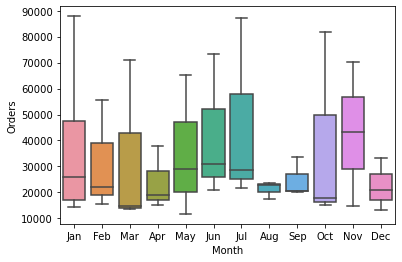

In [18]:
#Month-wise trend
sns.boxplot(x='Month', y='Orders', data=df)

In [19]:
df_series= df[["Date", "Orders"]].copy()

In [20]:
#Setting Date column as the Index of the data frame
df_series.set_index('Date',inplace=True)

In [21]:
df_series.head()

,Orders
Date,
2018-01-01,14375.67
2018-02-01,15635.32
2018-03-01,13526.79
2018-04-01,19046.00
2018-05-01,11703.39


### Let's check if the timeseries is stationary.

Using Augmented Dickey Fuller(ADF) TEST

The null hypothesis for this test is that there is a unit root(not stationary).


The alternate hypothesis is that the time series is stationary (or trend-stationary).

ARIMA depend on the values p, d, q

p = number of lags, AR terms

d = order of differencing

q = number of lagged forecast errors, MA terms

In [22]:
result = adfuller(df_series.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.186337
p-value: 0.679445


Since the p-value is 0.679 which is greater than significance level (0.05). Therefore, we cannot reject the null hypothesis that your time-series is non-stationary.

So, we need to do differencing in order to make timeseries stationary

#### Autocorrelation
Finding out the order of differencing, <strong>d</strong>, using auto correlation:

Rule 1: If the series has positive autocorrelations out to a high number of lags (say, 10 or more), then it probably needs a higher order of differencing.


Rule 2: If the lag-1 autocorrelation is zero or negative, or the autocorrelations are all small and patternless, then the series does not need a higher order of differencing. If the lag-1 autocorrelation is -0.5 or more negative, the series may be overdifferenced.  BEWARE OF OVERDIFFERENCING.

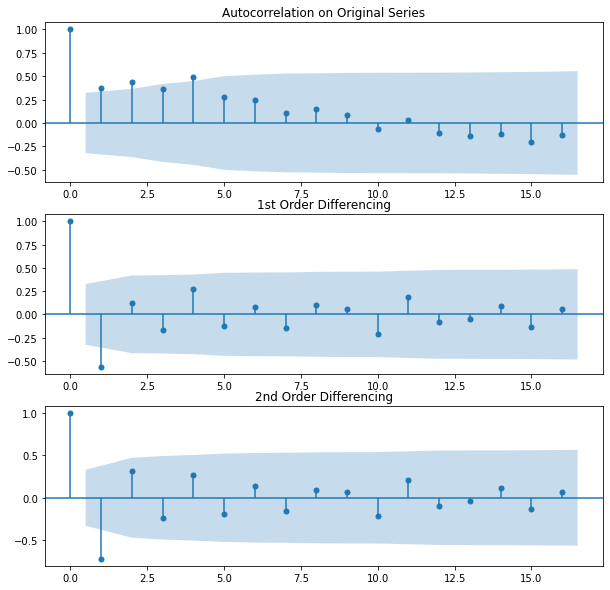

In [23]:
fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(311)
fig = plot_acf(df_series, ax=ax1,
               title="Autocorrelation on Original Series") 
ax2 = fig.add_subplot(312)
fig = plot_acf(df_series.diff().dropna(), ax=ax2, 
               title="1st Order Differencing")
ax3 = fig.add_subplot(313)
fig = plot_acf(df_series.diff().diff().dropna(), ax=ax3, 
               title="2nd Order Differencing")


<strong> The timeseries is stationary at d = 1 where only the first lag is above the significance level

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

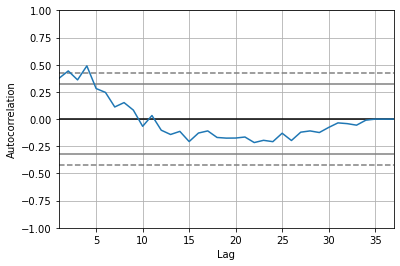

In [24]:
#autocorrelation plot for time series
autocorrelation_plot(df_series)


There is a positive correlation with first 8-9 lags, which looks significant for first 4 lags

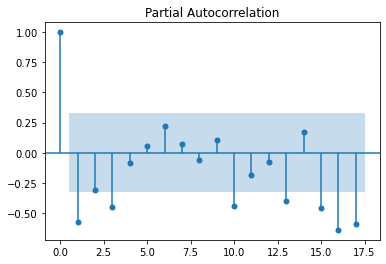

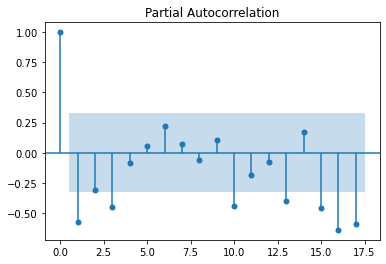

In [25]:
plot_pacf(df_series.diff().dropna(), lags=17)

C:\Users\jsingh\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\jsingh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS 

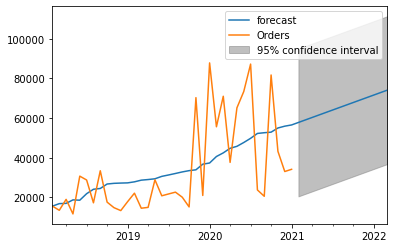

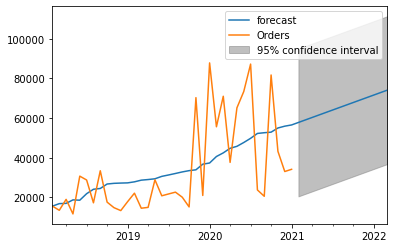

In [24]:
model = ARIMA(df_series, order=(0, 1, 1))
results = model.fit()
results.plot_predict(1, 50)

from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(df_series, order=(1, 1, 1))
results = model.fit()
results.plot_predict(1, 100)

In [42]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Orders   No. Observations:                   36
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -407.594
Method:                       css-mle   S.D. of innovations          19014.557
Date:                Mon, 08 Feb 2021   AIC                            821.188
Time:                        10:08:12   BIC                            825.938
Sample:                    02-01-2018   HQIC                           822.846
                         - 01-01-2021                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1253.5038    292.774      4.281      0.000     679.677    1827.331
ma.L1.D.Orders    -1.0000      0.133     -7.491      0.000      -1.262      -0.738
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [55]:
df_series.head()

,Orders
Date,
2018-01-01,14375.67
2018-02-01,15635.32
2018-03-01,13526.79
2018-04-01,19046.00
2018-05-01,11703.39


In [25]:
import pmdarima as pm

In [29]:
def arimamodel(df_series):
    automodel = pm.auto_arima(df_series, 
                              start_p=0, 
                              start_q=0,
                              test="adf",
                              seasonal=False,
                              trace=True)
    return automodel

In [30]:
def plotarima(n_periods, df_series, automodel):
    # Forecast
    fc, confint = automodel.predict(n_periods=n_periods, 
                                    return_conf_int=True)
    # mONTHLY index
    fc_ind = pd.date_range(df_series.index[df_series.shape[0]-1], 
                           periods=n_periods, freq="M")
    # Forecast series
    fc_series = pd.Series(fc, index=fc_ind)
    # Upper and lower confidence bounds
    lower_series = pd.Series(confint[:, 0], index=fc_ind)
    upper_series = pd.Series(confint[:, 1], index=fc_ind)
    # Create plot
    plt.figure(figsize=(10, 6))
    plt.plot(df_series)
    plt.plot(fc_series, color="red")
    plt.xlabel("date")
    plt.ylabel(df_series.name)
    plt.fill_between(lower_series.index, 
                     lower_series, 
                     upper_series, 
                     color="k", 
                     alpha=0.25)
    plt.legend(("past", "forecast", "95% confidence interval"),  
               loc="upper left")
    plt.show()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=837.896, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=826.371, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=821.934, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=835.926, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=822.434, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=823.283, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=824.683, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=819.775, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=820.703, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=821.159, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=824.454, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=821.880, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.226 seconds


AttributeError: 'DataFrame' object has no attribute 'name'

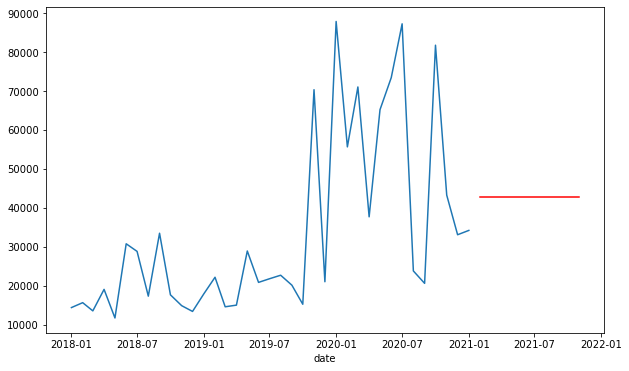

In [33]:
automodel = arimamodel(df_series)
plotarima(10, df_series, automodel)

In [38]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm


model = pm.auto_arima(df_series.Orders, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=822.434, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=837.896, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=826.371, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=821.934, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=835.926, Time=0.00 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=823.283, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=824.683, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=819.775, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=820.703, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=821.159, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=824.454, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=821.880, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.234 seconds
                               SARIMAX Results                                
Dep. Variable:       

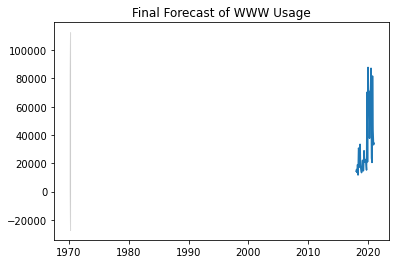

In [39]:
n_periods = 24
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df_series.Orders), len(df_series.Orders)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df_series.Orders)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of WWW Usage")
plt.show()